In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split 

In [40]:
nPerCluster = 200

th = np.linspace(0, 4*np.pi, nPerCluster)
r1 = 10
r2 = 20

a = [ r1*np.cos(th) + np.random.randn(nPerCluster)*3,
      r1*np.sin(th) + np.random.randn(nPerCluster)*3]
b = [ r2*np.cos(th) + np.random.randn(nPerCluster)*3,
      r2*np.sin(th) + np.random.randn(nPerCluster)*3]

labels = np.vstack((np.zeros((nPerCluster, 1)), np.ones((nPerCluster, 1))))

data_np = np.hstack((a, b)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels).float()


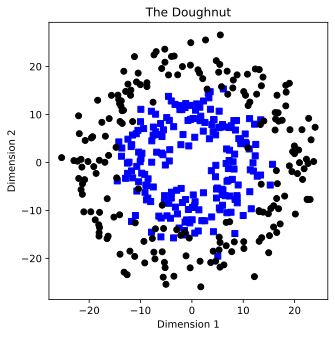

In [41]:
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko')
plt.title('The Doughnut')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [62]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.8)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)
# test_data.tensors[0].shape[0]
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])


In [71]:
class createModel(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)

        self.dr = dropoutRate
    
    def forward(self, data):
        # passing data through input layer
        x = F.relu(self.input(data))

        # passing the output of the previous layer from dropout
        # ** self.training is an internal variable of pytorch which is True when model is in training mode 
        x = F.dropout(x, p=self.dr, training=self.training)

        # passing the data through hidden layer and dropout
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        # output layer
        x = F.sigmoid(self.output(x))
        # no dropout here!
        return x

In [72]:
# test the model
testNet = createModel(0.5)
fakeData = torch.randn((10,2))
testYHat = testNet.forward(fakeData)
testYHat

tensor([[0.4701],
        [0.5522],
        [0.5748],
        [0.5060],
        [0.4748],
        [0.5208],
        [0.5501],
        [0.5047],
        [0.4291],
        [0.5363]], grad_fn=<SigmoidBackward0>)

In [73]:
def createANewModel(dropoutRate):
    ANN = createModel(dropoutRate)
    lossFunction = nn.BCELoss()
    optimizer = torch.optim.SGD(ANN.parameters(), lr=0.002)
    return ANN, lossFunction, optimizer

In [91]:
# train the model

epochs = 1000

def trainModel(ANN, lossFunction, optimizer):
    trainAcc = [] # this'd contain accuracies after all batches completes, basically 1 epoch
    testAcc = []  # this'd also contain accuracies after each epoch but on test data, (the last epoch accuracy ~= final accuracy??)
    for _ in range(epochs):
        ANN.train()
        batchAcc = []
        for x, y in train_loader:
            
            yHat = ANN.forward(x)
            # print(yHat)
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append((torch.mean(((yHat > 0.5) == y).float()) * 100).item())

        trainAcc.append(np.mean(batchAcc))

        ANN.eval()
        test_x, test_y = next(iter(test_loader))
        predLabels = ANN.forward(test_x)
        testAcc.append((torch.mean(((predLabels > 0.5) == test_y).float()) * 100).item())

    return trainAcc, testAcc


In [92]:
# test model
ANN, lossFunction, optimizer = createANewModel(0.0)
trainAcc, testAcc = trainModel(ANN, lossFunction, optimizer)

Actual Experiment

In [105]:
dropoutrates = np.arange(10)/10
results = np.zeros((len(dropoutrates), 2))

for di in range(len(dropoutrates)):
    ANN, lossFunction, optimizer = createANewModel(dropoutrates[di])
    trainAcc, testAcc = trainModel(ANN, lossFunction, optimizer)

    # taking mean of accuracies of last 100 epochs only
    results[di,0] = np.mean(trainAcc[-100:])
    results[di,1] = np.mean(testAcc[-100:])


In [106]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

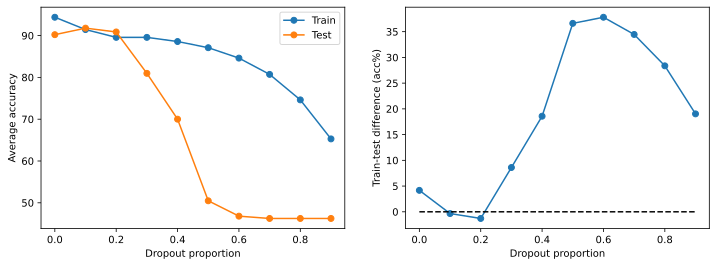

In [111]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(dropoutrates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutrates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()